# Machine Learning and Computer Vision
## Assigment 3

---

This assignment contains 2 programming exercises.


## Problem 1: Canny Edge Detection

In this problem, you are required to write a function that performs Canny Edge Detection1. The function has the following specifications:

• It takes in two inputs: a grayscale image (geisel.jpg), and a threshold te. 

• It returns the edge image.

• You are allowed the use of loops.


A brief description of the algorithm is given below. Make sure your function reproduces each step as given.

(i) Smoothing: 

It is inevitable that all images taken from a camera will contain some amount of noise. To prevent noise from being mistaken for edges, noise must be reduced. Therefore the image is first smoothed by applying a Gaussian filter. A Gaussian kernel with standard deviation σ = 1.4 (shown below) is to be used. 

You can perform this filtering step by using the scipy.signal.convolve2d( ) function.
<img src="markdown/fig1.png">

(ii) Finding Gradients: 

The next step is to find the horizontal and vertical gradients of the smoothed image using the Sobel operators. The gradient images in the x and y-direction, Gx and Gy are found by applying the kernels kx and ky given below. 
These operations can be performed using scipy.signal.convolve2d() in the same manner as before.
<img src="markdown/fig2.png">

The corresponding gradient magnitude image is computed using:
<img src="markdown/fig3.png">

and the edge direction image is calculated as follows:
<img src="markdown/fig4.png">

(iii) Non-maximum Suppression (NMS): 

The purpose of this step is to convert the thick edges in the gradient magnitude image to ”sharp” edges. This is done by preserving all local maxima in the gradient image, and deleting everything else. This is carried out by recursively performing the following steps for each pixel in the gradient image:

• Round the gradient direction θ to nearest 45◦, corresponding to the use of an 8-connected neighbourhood.

• Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient direction i.e. if the gradient direction is north (θ = 90◦), then compare with the pixels to the north and south.

• If the edge strength of the current pixel is largest; preserve the value of the edge strength. If not, suppress (remove) the value.

(iv) Thresholding: 

The edge-pixels remaining after the NMS step are (still) marked with their strength. Many of these will probably be true edges in the image, but some may be caused by noise or color variations. The simplest way to remove these would be to use a threshold, so that only edges stronger that a certain value would be preserved. Use the input te to perform thresholding on the non-maximum suppressed magnitude image.

Evaluate your canny edge detection function on geisel.jpg for a suitable value of te that retains the structural edges, and removes the noisy ones.

Things to turn in:

• Image afyer smoothing, the original gradient magnitude image, the image after NMS, and the final edge image after thresholding.

• The value for te that you used to produce the final edge image.

Text(0.5, 1.0, '(d) thresholding')

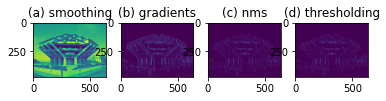

In [37]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from scipy import signal

#define a function rgb to gray
def rgb2gray(rgb):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    grayimg = np.dot(rgb[...,:3], rgb_weights)
    return grayimg

#define a function smoothing
def img_smoothing(img):
    #generate a guassian kernel
    t = 1 - np.abs(np.linspace(-1, 1, 7))
    kernel = t.reshape(7, 1) * t.reshape(1, 7)
    kernel /= kernel.sum()
    
    img_smoothed = signal.convolve2d(img, kernel, mode='same')
    return img_smoothed

#define a function finding gradients
def img_finding_gradients(img):
    #initialize
    img_gradients_norm = np.zeros((img.shape[0], img.shape[1]))
    img_gradients_angel = np.zeros((img.shape[0], img.shape[1]))
    
    #generate sobel operaters
    kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    ky = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    
    img_delta_x = signal.convolve2d(img, kx, mode='same')
    img_delta_y = signal.convolve2d(img, kx, mode='same')
    
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            img_gradients_norm[i][j] = (img_delta_x[i][j]**2+img_delta_y[i][j]**2)**(1/2)
            img_gradients_angel[i][j] = np.arctan(img_delta_y[i][j]/img_delta_x[i][j])
    return img_gradients_norm, img_gradients_angel

#define a function for Non-maximum Suppression
def non_maximum_suppression(norm, phase):
    img_with_nms = np.zeros(norm.shape)
    
    for i in range(img_with_nms.shape[0]):
        for j in range(img_with_nms.shape[1]):
            #initialize the degrees
            if phase[i][j] < 0:
                phase[i][j] += 360
                
            if ((j+1) < img_with_nms.shape[1]) and ((j-1) >= 0) and ((i+1) < img_with_nms.shape[0]) and ((i-1) >= 0):
                # 0 degrees
                if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
                    if norm[i][j] >= norm[i][j + 1] and norm[i][j] >= norm[i][j - 1]:
                        img_with_nms[i][j] = norm[i][j]
                # 45 degrees
                if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
                    if det[i][j] >= det[i - 1][j + 1] and det[i][j] >= norm[i + 1][j - 1]:
                        img_with_nms[i][j] = norm[i][j]
                # 90 degrees
                if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
                    if det[i][j] >= det[i - 1][j] and det[i][j] >= det[i + 1][j]:
                        img_with_nms[i][j] = norm[i][j]
                # 135 degrees
                if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
                    if det[i][j] >= det[i - 1][j - 1] and det[i][j] >= det[i + 1][j + 1]:
                        img_with_nms[i][j] = norm[i][j]
            
    return img_with_nms

#define a function for thresholding
def img_thresholding(img,te):
    img_with_thresholding = img
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i][j] <= te):
                img_with_thresholding[i][j] = 0
    return img_with_thresholding

#Canny Edge Detection Function
def canny_edge(img, te):
    img_smoothed = img_smoothing(img)
    img_strength, img_phase = img_finding_gradients(img_smoothed)
    img_after_NMS = non_maximum_suppression(img_strength, img_phase)
    detected_img = img_thresholding(img_after_NMS,te)
    return detected_img

#Import image here
# threshold
img = imread('geisel.jpg')
img_gray = rgb2gray(img)
te = 10
plt.imshow(canny_edge(img_gray, te))
# Convert to Gray scale image, select Threshold
# Sample call

plt.subplot(1, 4, 1) 
plt.imshow(img_smoothing(img_gray))
plt.title('(a) smoothing')

gradients, phases = img_finding_gradients(img_smoothing(img_gray))
plt.subplot(1, 4, 2) 
plt.imshow(gradients)
plt.title('(b) gradients')

plt.title('(c) nms'plt.subplot(1, 4, 3) 
plt.imshow(non_maximum_suppression(gradients, phases))
)

plt.subplot(1, 4, 4) 
plt.imshow(img_thresholding(non_maximum_suppression(gradients, phases),te))
plt.title('(d) thresholding')


## Problem 2: Bilateral filter

Now, we will discuss a non-local filter, Bilateral filter.

The bilateral filter is a denoising algorithm that reads as:
    <img src="markdown/fig7.png">

1. Create a test_imbilateral(img, sigma) function that loads the image x = castle and adds additive white Gaussian noise of standard deviation σ = 10

2. Create in imbilateral_naive(img, sigma, s1, s2, h), a function that implements the bilateral filter (except around boundaries) with four loops.

3. test your function on y with s1 = s2 = 10 and h = 1. Zoom on the results to check that your functions are consistent with the following ones:
    <img src="markdown/fig8.png">

4. Create function imbilateral(y, sigma, s1, s2, h)that implements the bilateral filter including around boundaries. The idea is again to switch the k, l loops with the i, j loops, and then make use of imshift. The final code should read with only two loops and deal with boundary conditions.

5. Compare the computation times.

6. Increase the noise level, and play with the search window sizes s1 and s2 and filtering parameter h.

<ipython-input-11-03eac1e10222>:27: RuntimeWarning: overflow encountered in ubyte_scalars
  sum_1 = kernel(h, sigma, (img[i+k][j+l]-img[i][j])**2) + sum_1
<ipython-input-11-03eac1e10222>:28: RuntimeWarning: overflow encountered in ubyte_scalars
  sum_2 = kernel(h, sigma, (img[i+k][j+l]-img[i][j])**2) * img[i+k][j+l] + sum_2


Text(0.5, 1.0, '(d) Spatial bilateral')

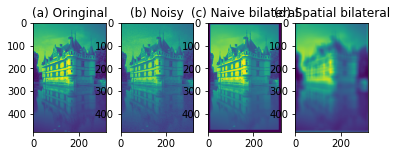

In [11]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt

#define a function to load images and adds additive white Gaussian noise of standard deviation σ
def test_imbilateral(img, sigma):
    noise = sigma*np.random.randn(img.shape[0], img.shape[1])
    test_img = img + noise
    return test_img

#define a function to generate kernels
def kernel(h, sigma, alpha):
    middle_value = max(alpha-2*sigma**2,0)
    kernel = np.exp(-middle_value/16*h*sigma**2)
    return kernel

#define a function for naive bilateral
def imbilateral_naive(img, sigma, s1, s2, h):
    img_bilateral = np.zeros(img.shape)
    
    for i in range(s1, img.shape[0]-s1):
        for j in range(s2, img.shape[1]-s2):
            sum_1 = 0
            sum_2 = 0
            for k in range(-s1, s1+1):
                for l in range(-s2, s2+1):
                    sum_1 = kernel(h, sigma, (img[i+k][j+l]-img[i][j])**2) + sum_1
                    sum_2 = kernel(h, sigma, (img[i+k][j+l]-img[i][j])**2) * img[i+k][j+l] + sum_2
            img_bilateral[i][j] = sum_2/sum_1
            
    return img_bilateral

#Quote imshift function in assignment 1
def imshift_no_loops(x, k, l):
    xshifted = np.roll(x, k, axis=0)
    xshifted = np.roll(xshifted, l, axis=1)
    return xshifted

#define a function for bilateral with shift
def imbilateral(img, sigma, s1, s2, h):
    img_origin = img
    img_bilateral = np.empty((img.shape[0],img.shape[1]))
    Z = np.empty((img.shape[0],img.shape[1]))

    '''
    Edition 1
    for k in range(-s1, s1+1):
        for l in range(-s2, s2+1):
            imshift = imshift_no_loops(img, k, l)
            alpha = np.square(imshift - img_origin)
            Z = kernel(h, sigma, alpha) + Z
            img_bilateral = np.multiply(kernel(h, sigma, alpha),imshift) + img_bilateral
            img = img_origin
    img_bilateral = np.divide(img_bilateral,Z)
    '''
    for k in range(-s1, s1+1):
        for l in range(-s2, s2+1):
            imshift = imshift_no_loops(img, k, l)
            alpha = np.square(imshift - img_origin)
            middle_value_1 = np.full(alpha.shape, 2*sigma**2)
            middle_value_2 = np.full(alpha.shape, 16*h*sigma**2)
            add_value = alpha - middle_value_1
            max_value = (add_value >= 0)
            div_value = np.divide((-1)*max_value, middle_value_2)
            kernel = np.exp(div_value)
            Z = kernel + Z
            img_bilateral = np.multiply(kernel, imshift) + img_bilateral
            img = img_origin
    img_bilateral = np.divide(img_bilateral,Z)
    
    return img_bilateral
#note: noise can be generated using 
# noise: sigma*np.random.randn(n1,n2)

#Import image here
# Sample call
# castle.png
img = imread('castle.png')
s1 =  10
s2 =  10
h = 1
sigma = 10

plt.subplot(1, 4, 1) 
plt.imshow(img)
plt.title('(a) Oringinal')

plt.subplot(1, 4, 2) 
plt.imshow(test_imbilateral(img, sigma))
plt.title('(b) Noisy')

plt.subplot(1, 4, 3) 
plt.imshow(imbilateral_naive(img, sigma, s1, s2, h))
plt.title('(c) Naive bilateral')

plt.subplot(1, 4, 4) 
plt.imshow(imbilateral(img, sigma, s1, s2, h))
plt.title('(d) Spatial bilateral')

## Problem 2 Adaptive Histogram Equalization
It is often found in image processing and related fields that real world data is unsuitable for direct use. This warrants the inclusion of pre-processing steps before any other operations are performed. An example of this is histogram equalization (HE) and its extension adaptive histogram equalization (AHE).
The goal of this problem is to implement a function for AHE as described in Chapter 1 of Adaptive Histogram Equalization - A Parallel Implementation2. The function has the following specifications:

(i) The desired function AHE() takes two inputs: the image ("beach.png") im and the contextual region size win_size.

(ii) Using the pseudocode in Algorithm as a reference, compute the enhanced image after AHE.

(iii) You may use loops if necessary. You should not make use of any inbuilt functions for AHE or HE.

(iv) The function returns one output: the enhanced image after AHE.

<img src="markdown/fig6.png">

Evaluate your function on the image beach.png for win size = 33, 65 and 129. In your report, include the original image, the 3 images after AHE. Make sure to resize all images to ensure they do not take up too much space. Additionally, include your answers (no more than three sentences each) to the following questions:

• How does the original image qualitatively compare to the images after AHE?



Text(0.5, 1.0, '(d) win_size=129')

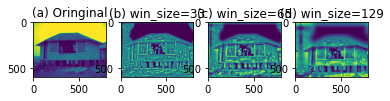

In [4]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt

def AHE(img, win_size):
    length = round(win_size/2)
    img_enhanced = np.zeros(img.shape)
    img_padding = np.pad(img,((length,length),(length,length)),'symmetric')
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rank = 0
            for k in range(-length, length+1):
                for l in range(-length, length+1):
                    if (img_padding[i][j] > img_padding[i+k][j+l]):
                        rank = rank + 1
            img_enhanced[i][j] = rank*255/(win_size*win_size)
    return img_enhanced


#Import image here
#Sample call
#Plotting code below
img = imread('beach.png')

win_size_1 = 33
win_size_2 = 65
win_size_3 = 129

plt.subplot(1, 4, 1) 
plt.imshow(img)
plt.title('(a) Oringinal')

plt.subplot(1, 4, 2) 
plt.imshow(AHE(img, win_size_1))
plt.title('(b) win_size=33')

plt.subplot(1, 4, 3) 
plt.imshow(AHE(img, win_size_2))
plt.title('(c) win_size=65')

plt.subplot(1, 4, 4) 
plt.imshow(AHE(img, win_size_3))
plt.title('(d) win_size=129')

## Conclusion

Have you accomplished all parts of your assignment? What concepts did you used or learned in this assignment? What difficulties have you encountered? Explain your result for each section. Please wirte one or two short paragraph in the below Markdown window (double click to edit).

**** Your Conclusion: ****

--




---
** Submission Instructions**  
Remember to submit you pdf version of this notebook to Gradescope. You can find the export option at File $\rightarrow$ Download as $\rightarrow$ PDF via LaTeX